In [4]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
import shutil
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [5]:
if os.path.exists('dataset'):
    shutil.rmtree('dataset')
shutil.copytree('/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/', 'dataset')

'dataset'

In [6]:
files = os.listdir('dataset/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00334_121


(256, 192, 3)


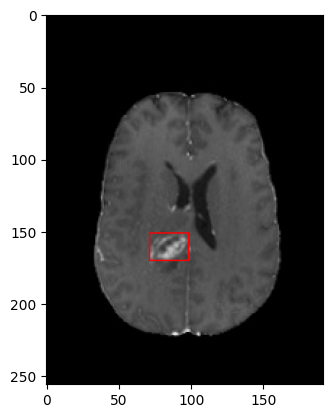

In [7]:
with open(os.path.join('dataset/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

img = cv2.imread(os.path.join('dataset/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [8]:
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

310 75
296 75


In [9]:
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('dataset/images/train', image))

In [10]:
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

296 75
296 75


In [11]:
val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('dataset/images/val'):
    shutil.rmtree('dataset/images/val')
if os.path.exists('dataset/labels/val'):
    shutil.rmtree('dataset/labels/val')

os.mkdir('./dataset/images/val')
os.mkdir('./dataset/labels/val')

for image in val_images:
    shutil.move(os.path.join('dataset/images/train', image), 'dataset/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('dataset/labels/train', label), 'dataset/labels/val')

In [12]:
text = """
path: /kaggle/working/dataset
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./fixed_path.yaml", 'w') as file:
    file.write(text)

# EDA

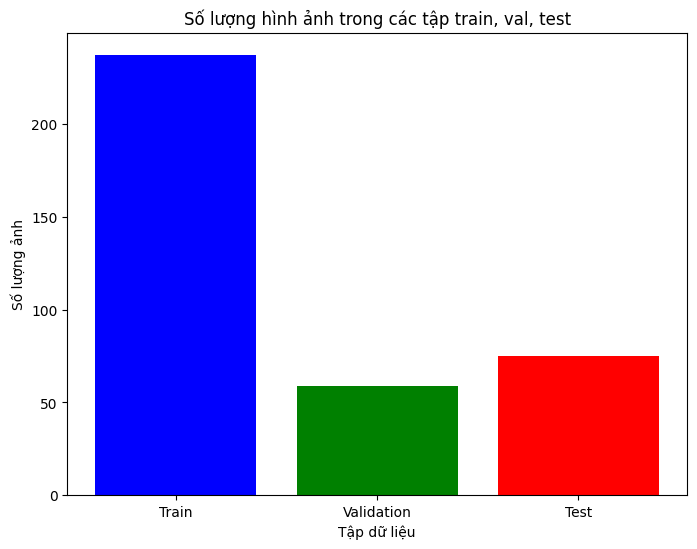

In [10]:
# Đường dẫn tới dữ liệu
dataset_path = 'dataset'
train_images_path = os.path.join(dataset_path, 'images', 'train')
val_images_path = os.path.join(dataset_path, 'images', 'val')
test_images_path = os.path.join(dataset_path, 'images', 'test')

# Đếm số lượng ảnh trong từng tập
num_train_images = len(os.listdir(train_images_path))
num_val_images = len(os.listdir(val_images_path))
num_test_images = len(os.listdir(test_images_path))

# Plot số lượng ảnh
plt.figure(figsize=(8, 6))
plt.bar(['Train', 'Validation', 'Test'], [num_train_images, num_val_images, num_test_images], color=['blue', 'green', 'red'])
plt.title('Số lượng hình ảnh trong các tập train, val, test')
plt.xlabel('Tập dữ liệu')
plt.ylabel('Số lượng ảnh')
plt.show()

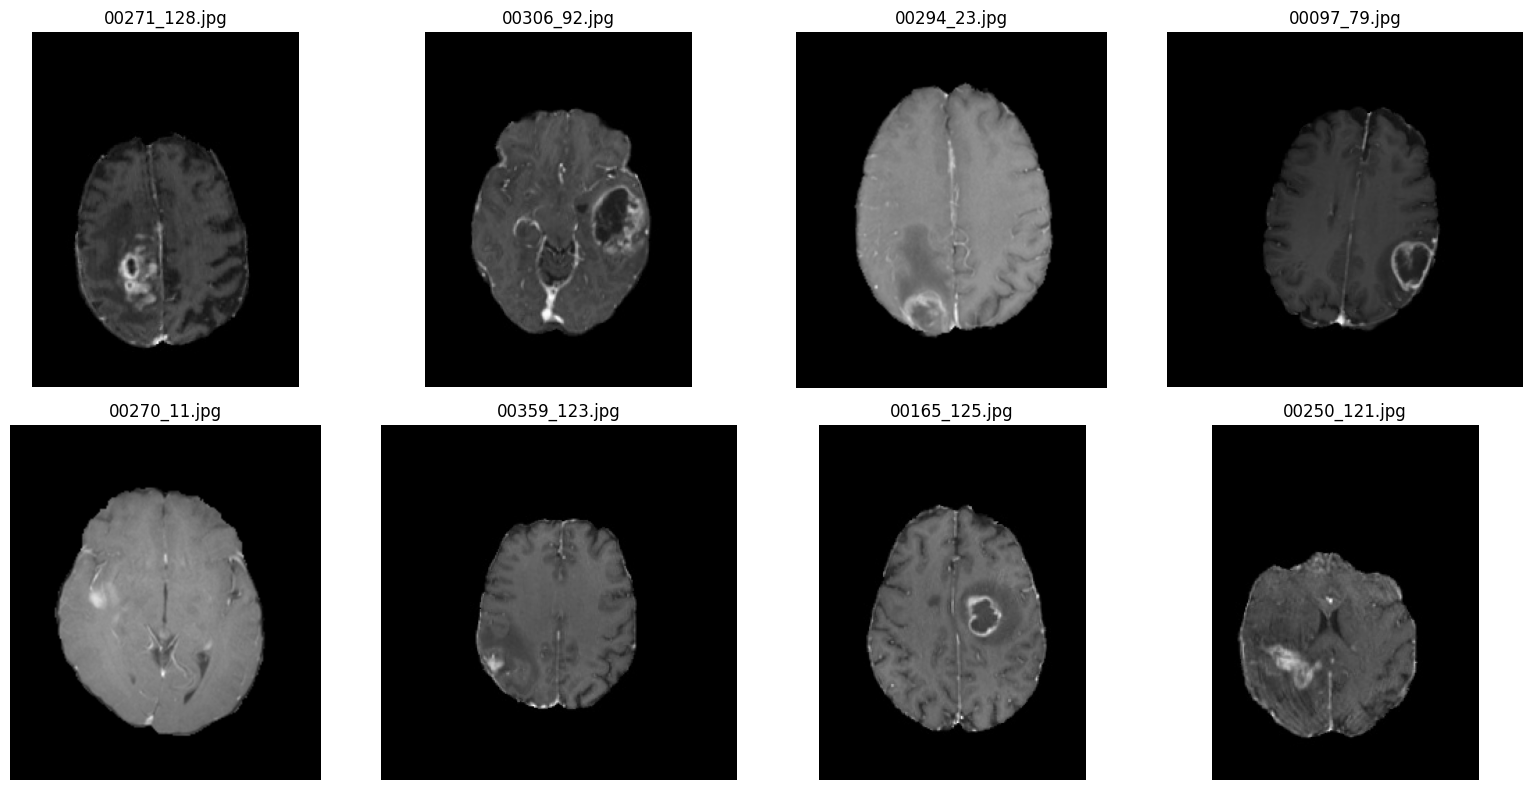

In [11]:
# Đường dẫn đến thư mục chứa hình ảnh
data_dir = 'dataset/images/train'

# Lấy danh sách tên các hình ảnh
image_files = os.listdir(data_dir)

# Số lượng hình ảnh bạn muốn hiển thị
num_rows = 2
num_cols = 4

# Lựa chọn ngẫu nhiên các hình ảnh từ tập dữ liệu
selected_images = np.random.choice(image_files, size=num_rows*num_cols, replace=False)

# Tạo một lưới hình ảnh với kích thước đã chọn
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))

# Lặp qua từng hình ảnh để hiển thị
for i, image_file in enumerate(selected_images):
    # Đọc hình ảnh
    img_path = os.path.join(data_dir, image_file)
    img = cv2.imread(img_path)
    
    # Chuyển đổi màu sắc của hình ảnh từ BGR sang RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Hiển thị hình ảnh trên một ô của lưới
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(img)
    ax.set_title(image_file)
    ax.axis('off')

plt.tight_layout()
plt.show()

Số lượng ảnh huấn luyện: 237
Số lượng mẫu positive: 146
Số lượng mẫu negative: 91


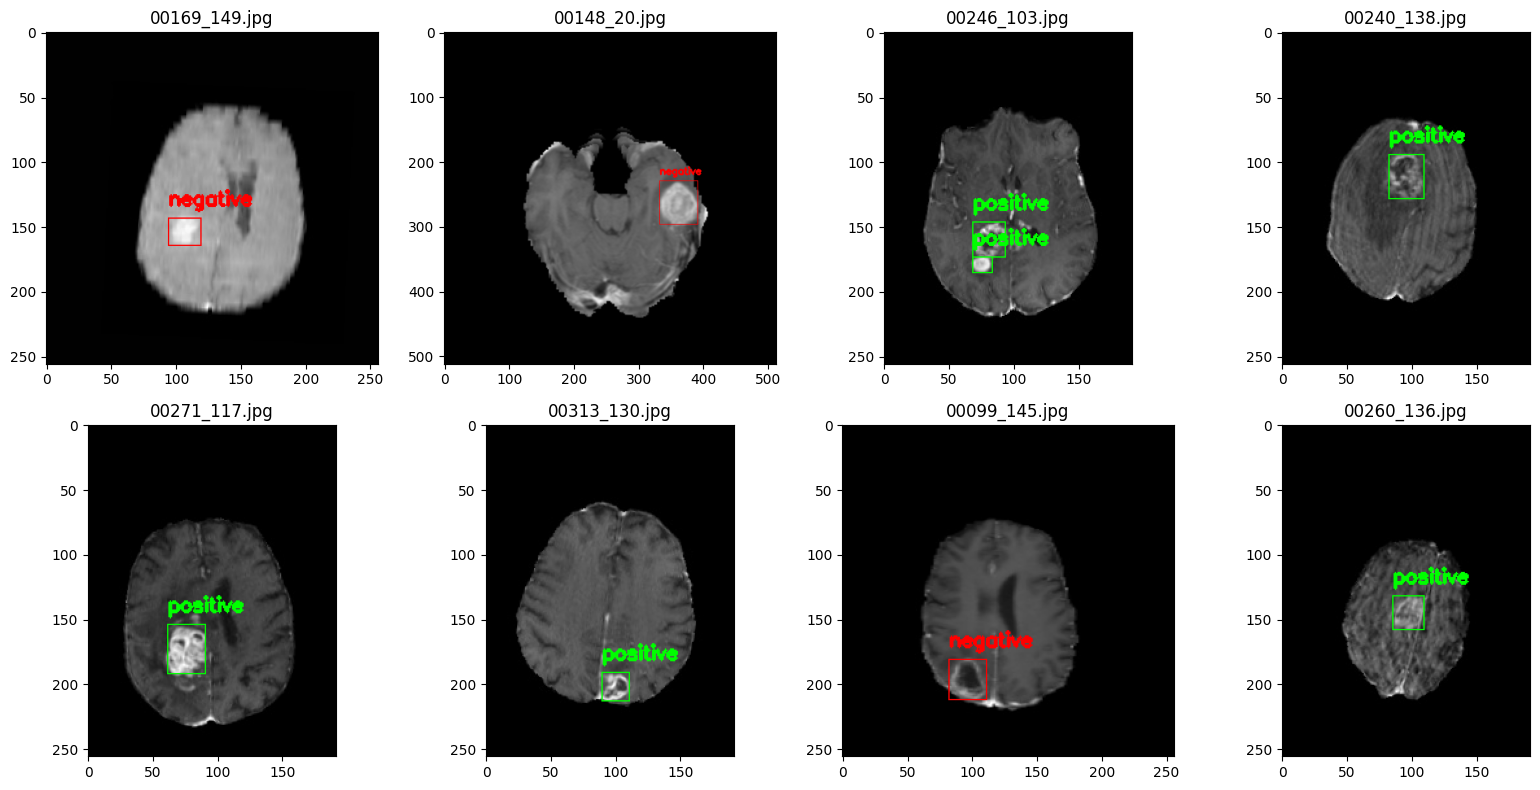

In [12]:
# Định nghĩa hàm để vẽ bounding box lên ảnh
def draw_bbox(img, labels):
    for label in labels:
        tumor_class, x, y, w, h = map(float, label.split())
        x_pt1 = int((x - w/2) * img.shape[1])
        y_pt1 = int((y - h/2) * img.shape[0])
        x_pt2 = int((x + w/2) * img.shape[1])
        y_pt2 = int((y + h/2) * img.shape[0])

        if tumor_class == 1:
            colour = (0, 255, 0) 
            tumor_type = "positive"
        else:
            colour = (255, 0, 0)
            tumor_type = "negative"
        cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
        cv2.putText(img, tumor_type, (x_pt1, y_pt1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour, 2)
    return img

# Đường dẫn tới dữ liệu
dataset_path = 'dataset'
train_images_path = os.path.join(dataset_path, 'images', 'train')
train_labels_path = os.path.join(dataset_path, 'labels', 'train')

# Lấy danh sách tệp ảnh huấn luyện và hiển thị một số thông tin
train_images = os.listdir(train_images_path)
num_train_images = len(train_images)
print("Số lượng ảnh huấn luyện:", num_train_images)

# Đếm số lượng các lớp
positive_count = 0
negative_count = 0
for label_file in os.listdir(train_labels_path):
    with open(os.path.join(train_labels_path, label_file), 'r') as f:
        label = f.readline()
        tumor_class = int(label.split()[0])
        if tumor_class == 1:
            positive_count += 1
        else:
            negative_count += 1

print("Số lượng mẫu positive:", positive_count)
print("Số lượng mẫu negative:", negative_count)


# Hiển thị một số ảnh mẫu cùng với nhãn
num_rows = 2
num_cols = 4
plt.figure(figsize=(16, 8))
for i, image_name in enumerate(random.sample(train_images, num_rows*num_cols), 1):
    img_path = os.path.join(train_images_path, image_name)
    label_path = os.path.join(train_labels_path, os.path.splitext(image_name)[0] + '.txt')

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with open(label_path, 'r') as f:
        labels = f.readlines()

    img_with_bbox = draw_bbox(img, labels)

    plt.subplot(num_rows, num_cols, i)
    plt.imshow(img_with_bbox)
    plt.title(image_name)
plt.tight_layout()
plt.show()

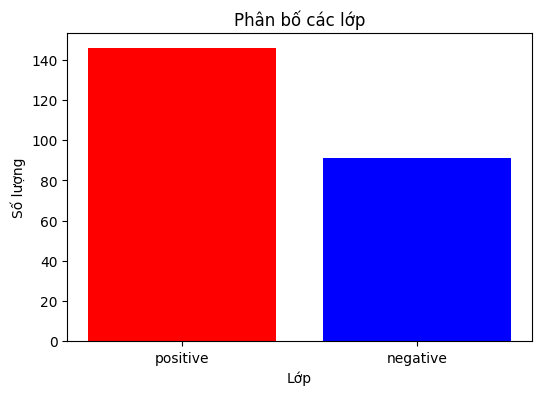

In [16]:
# Kiểm tra sự cân bằng giữa các lớp
class_counts = {'positive': positive_count, 'negative': negative_count}
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['red', 'blue'])
plt.title("Phân bố các lớp")
plt.xlabel("Lớp")
plt.ylabel("Số lượng")
plt.show()

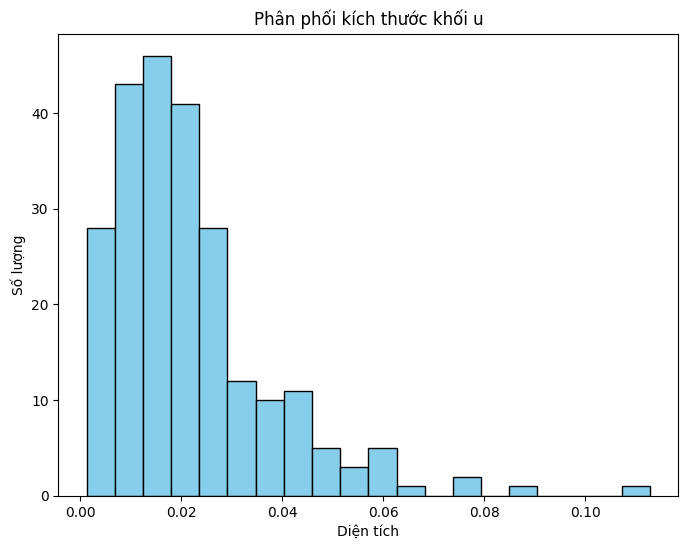

In [13]:

# Phân phối kích thước khối u
tumor_sizes = []
for label_file in os.listdir(train_labels_path):
    with open(os.path.join(train_labels_path, label_file), 'r') as f:
        label = f.readline()
        tumor_size = float(label.split()[3]) * float(label.split()[4])  # Diện tích = width * height
        tumor_sizes.append(tumor_size)

plt.figure(figsize=(8, 6))
plt.hist(tumor_sizes, bins=20, color='skyblue', edgecolor='black')
plt.title("Phân phối kích thước khối u")
plt.xlabel("Diện tích")
plt.ylabel("Số lượng")
plt.show()

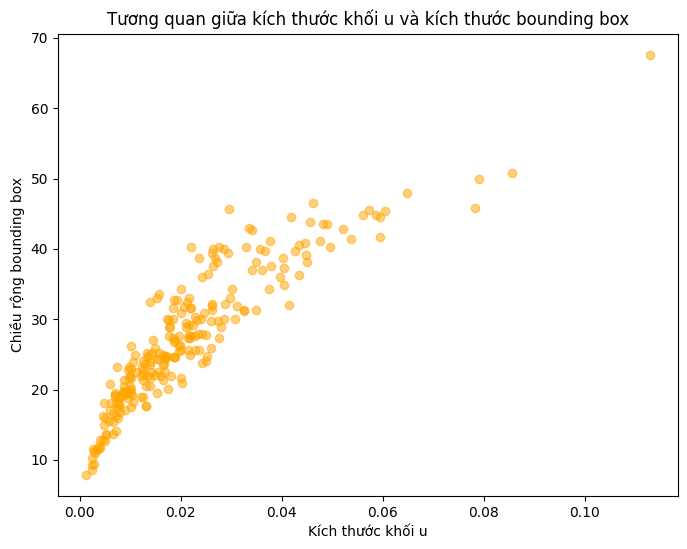

In [17]:
# Tương quan giữa kích thước khối u và kích thước bounding box
plt.figure(figsize=(8, 6))
plt.scatter(tumor_sizes, bbox_sizes[:, 0], color='orange', alpha=0.5)
plt.title("Tương quan giữa kích thước khối u và kích thước bounding box")
plt.xlabel("Kích thước khối u")
plt.ylabel("Chiều rộng bounding box")
plt.show()

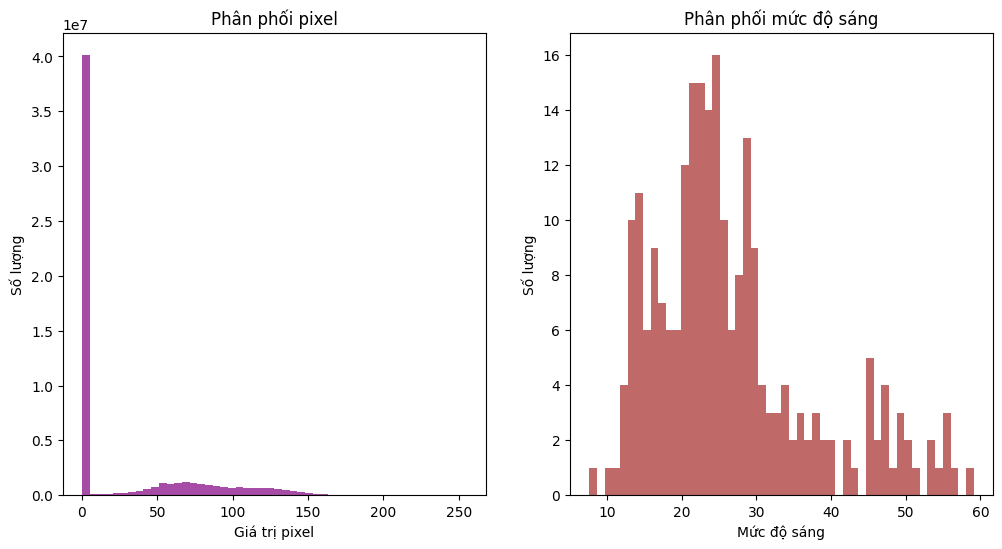

In [18]:
# Phân phối pixel và mức độ sáng của ảnh
pixel_distribution = []
brightness = []
for image_file in os.listdir(train_images_path):
    img = cv2.imread(os.path.join(train_images_path, image_file))
    pixel_distribution.extend(img.flatten())
    brightness.append(np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(pixel_distribution, bins=50, color='purple', alpha=0.7)
plt.title("Phân phối pixel")
plt.xlabel("Giá trị pixel")
plt.ylabel("Số lượng")

plt.subplot(1, 2, 2)
plt.hist(brightness, bins=50, color='brown', alpha=0.7)
plt.title("Phân phối mức độ sáng")
plt.xlabel("Mức độ sáng")
plt.ylabel("Số lượng")

plt.show()

# Data processing for Faster R-CNN

In [13]:
from torchvision.transforms import functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

class BuildObjectDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, split='train'):
        self.root = root
        self.transforms = transforms
        self.split = split

        self.images = []
        self.labels = []

        image_folder = os.path.join(root, "images", split)
        label_folder = os.path.join(root, "labels", split)
        images = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')])
        labels = sorted([f for f in os.listdir(label_folder) if f.endswith('.txt')])
        assert len(images) == len(labels), f"Số lượng hình ảnh và nhãn không khớp trong thư mục {split}!"
        self.images = [os.path.join(split, f) for f in images]
        self.labels = [os.path.join(split, f) for f in labels]

        # Kiểm tra xem có dữ liệu nào không
        if len(self.images) == 0:
            raise ValueError("Không tìm thấy dữ liệu hình ảnh trong thư mục images!")
        if len(self.labels) == 0:
            raise ValueError("Không tìm thấy dữ liệu nhãn trong thư mục labels!")

        print(f"Số lượng mẫu trong {split} dataset:", len(self.images))

    def __getitem__(self, index):
        image_path = os.path.join(self.root,"images", self.images[index])
        label_path = os.path.join(self.root,"labels", self.labels[index])

        # Open image
        with open(image_path, "rb") as f:
            image = Image.open(f).convert("RGB")

        # Read bounding box labels
        with open(label_path, "r") as f:
            labels = f.readline().strip().split()
            class_id, x_center, y_center, width, height = map(float, labels)

        # Convert bounding box from YOLO format to [x_min, y_min, x_max, y_max] format
        x_min = (x_center - width / 2) * image.width
        y_min = (y_center - height / 2) * image.height
        x_max = (x_center + width / 2) * image.width
        y_max = (y_center + height / 2) * image.height

        # Apply transformations to image
        if self.transforms is not None:
            # Convert bounding box coordinates to [x_min, y_min, x_max, y_max] format
            bboxes = [[x_min, y_min, x_max, y_max]]
            augmented = self.transforms(image=np.array(image), bboxes=bboxes, category_ids=[class_id])
            image = augmented['image']
            bboxes = augmented['bboxes']
        
        image = image.float() / 255.0
        # Process target separately
        target = {
            "boxes": torch.tensor(bboxes, dtype=torch.float32),
            "labels": torch.tensor([class_id], dtype=torch.int64),
        }

        return image, target


    def __len__(self):
        return len(self.images)

# Define the data loader
def collate_fn(batch):
    return tuple(zip(*batch))

import torchvision.transforms as transforms

transforms_train = A.Compose([
    A.HorizontalFlip(),
    A.OneOf([
        A.ColorJitter(hue=0.1),
        A.Equalize(by_channels=False),
        A.FancyPCA(),
        A.GaussNoise(),
        A.ImageCompression(),
        A.ISONoise(),
        A.RandomGamma(),
        A.RandomToneCurve(),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
        A.AdvancedBlur(p=0.1)
    ]),
    ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['category_ids']))

transforms_valid = ToTensorV2()

# Split dataset into train, test, and val
root_dir = './dataset'
train_dataset = BuildObjectDetectionDataset(root=root_dir, split='train', transforms=transforms_train)
test_dataset = BuildObjectDetectionDataset(root=root_dir, split='test', transforms=transforms_valid)
val_dataset = BuildObjectDetectionDataset(root=root_dir, split='val', transforms=transforms_valid)

# Define batch size
batch_size = 4

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn)

Số lượng mẫu trong train dataset: 237
Số lượng mẫu trong test dataset: 75
Số lượng mẫu trong val dataset: 59


In [14]:
!pip install pycocotools 
!pip install torchmetrics
!pip install torchvision>=0.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 11.1 MB/s eta 0:00:0000:01


In [15]:
import torch
from torchmetrics.detection import MeanAveragePrecision

def calculate_mAP(model, data_loader, device):
    model.eval()
    map_metric_50 = MeanAveragePrecision(iou_thresholds=[0.5])
    map_metric_50_95 = MeanAveragePrecision(iou_thresholds=[0.5, 0.95])

    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            # Chuyển từng hình ảnh sang tensor và di chuyển đến device
            images = [image.to(device) for image in images]
            
            # Chuyển targets sang tensor nếu chưa phải
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Tính toán đầu ra của mô hình
            outputs = model(images)
            
            # Tính toán mAP@50
            map_metric_50.update(outputs, targets)

            # Tính toán mAP@50-95
            map_metric_50_95.update(outputs, targets)

    # Lấy giá trị mAP cuối cùng
    mAP_50 = map_metric_50.compute()
    mAP_50_95 = map_metric_50_95.compute()
    return mAP_50, mAP_50_95

In [19]:
# Load pre-trained Faster RCNN model
model_fasterrcnn = fasterrcnn_resnet50_fpn(weights='DEFAULT')

# Replace the classifier with a new one
num_classes = 2  # 1 class (tumor) + background
in_features = model_fasterrcnn.roi_heads.box_predictor.cls_score.in_features
model_fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_fasterrcnn.to(device)

# Define the optimizer
params = [p for p in model_fasterrcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [20]:
# Khởi tạo list để lưu loss và mAP trong quá trình huấn luyện
train_losses = []
mAP50_values = []
mAP50_95_values = []
num_epochs = 200

# Training loop
for epoch in range(num_epochs):
    model_fasterrcnn.train()
    epoch_loss = 0.0  # Tích lũy loss trong mỗi epoch
    
    for images, targets in tqdm(train_loader):
        # Chuyển từng hình ảnh sang tensor và di chuyển đến device
        images = [image.to(device) for image in images]
        
        # Chuyển targets sang tensor nếu chưa phải
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model_fasterrcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()  # Cộng dồn loss trong mỗi batch
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    
    # Calculate mAP metrics after each epoch
    mAP50, mAP50_95 = calculate_mAP(model_fasterrcnn, val_loader, device)
    mAP50, mAP50_95 = mAP50['map'].item(), mAP50_95['map'].item()
    mAP50_values.append(mAP50)
    mAP50_95_values.append(mAP50_95)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_epoch_loss}, mAP50: {mAP50}, mAP50-95: {mAP50_95}")

100%|██████████| 59/59 [00:03<00:00, 16.62it/s]


Epoch 1/200, Train Loss: 0.14278017356991768, mAP50: 0.34396490454673767, mAP50-95: 0.17198245227336884


100%|██████████| 59/59 [00:03<00:00, 16.56it/s]


Epoch 2/200, Train Loss: 0.07877469062805176, mAP50: 0.38066306710243225, mAP50-95: 0.190761998295784


100%|██████████| 59/59 [00:03<00:00, 16.55it/s]


Epoch 3/200, Train Loss: 0.07079883832484483, mAP50: 0.4129023551940918, mAP50-95: 0.20760630071163177


100%|██████████| 59/59 [00:03<00:00, 16.58it/s]


Epoch 4/200, Train Loss: 0.05689229707544049, mAP50: 0.39479130506515503, mAP50-95: 0.19739565253257751


100%|██████████| 59/59 [00:03<00:00, 16.45it/s]


Epoch 5/200, Train Loss: 0.05115263390665253, mAP50: 0.43292921781539917, mAP50-95: 0.21687714755535126


100%|██████████| 59/59 [00:03<00:00, 16.63it/s]


Epoch 6/200, Train Loss: 0.04352907479430238, mAP50: 0.42775145173072815, mAP50-95: 0.2192762792110443


100%|██████████| 59/59 [00:03<00:00, 16.54it/s]


Epoch 7/200, Train Loss: 0.04025926368000607, mAP50: 0.45448675751686096, mAP50-95: 0.23099374771118164


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 8/200, Train Loss: 0.03611047465043763, mAP50: 0.45826980471611023, mAP50-95: 0.22942610085010529


100%|██████████| 59/59 [00:03<00:00, 16.63it/s]


Epoch 9/200, Train Loss: 0.031966280673320094, mAP50: 0.4495992362499237, mAP50-95: 0.22479961812496185


100%|██████████| 59/59 [00:03<00:00, 16.67it/s]


Epoch 10/200, Train Loss: 0.030490852240473033, mAP50: 0.44099661707878113, mAP50-95: 0.22146089375019073


100%|██████████| 59/59 [00:03<00:00, 16.61it/s]


Epoch 11/200, Train Loss: 0.03420019621650378, mAP50: 0.44326457381248474, mAP50-95: 0.22163228690624237


100%|██████████| 59/59 [00:03<00:00, 16.60it/s]


Epoch 12/200, Train Loss: 0.028531306733687718, mAP50: 0.4611506462097168, mAP50-95: 0.2305753231048584


100%|██████████| 59/59 [00:03<00:00, 16.49it/s]


Epoch 13/200, Train Loss: 0.027564368045811232, mAP50: 0.45315971970558167, mAP50-95: 0.23586203157901764


100%|██████████| 59/59 [00:03<00:00, 16.71it/s]


Epoch 14/200, Train Loss: 0.02564313181695373, mAP50: 0.44990968704223633, mAP50-95: 0.22524604201316833


100%|██████████| 59/59 [00:03<00:00, 16.63it/s]


Epoch 15/200, Train Loss: 0.02502683596200465, mAP50: 0.4413827061653137, mAP50-95: 0.2209913730621338


100%|██████████| 59/59 [00:03<00:00, 16.49it/s]


Epoch 16/200, Train Loss: 0.02538141895396014, mAP50: 0.45445647835731506, mAP50-95: 0.22722823917865753


100%|██████████| 59/59 [00:03<00:00, 16.51it/s]


Epoch 17/200, Train Loss: 0.021583833557087928, mAP50: 0.46373307704925537, mAP50-95: 0.23681703209877014


100%|██████████| 59/59 [00:03<00:00, 16.69it/s]


Epoch 18/200, Train Loss: 0.022995288770956298, mAP50: 0.4605643153190613, mAP50-95: 0.23052968084812164


100%|██████████| 59/59 [00:03<00:00, 16.72it/s]


Epoch 19/200, Train Loss: 0.020361687898791083, mAP50: 0.47253498435020447, mAP50-95: 0.23662109673023224


100%|██████████| 59/59 [00:03<00:00, 16.68it/s]


Epoch 20/200, Train Loss: 0.01974890208997143, mAP50: 0.46980658173561096, mAP50-95: 0.23490329086780548


100%|██████████| 59/59 [00:03<00:00, 16.63it/s]


Epoch 21/200, Train Loss: 0.019976556500963246, mAP50: 0.4657864272594452, mAP50-95: 0.23601417243480682


100%|██████████| 59/59 [00:03<00:00, 16.46it/s]


Epoch 22/200, Train Loss: 0.01870438198384363, mAP50: 0.4510982036590576, mAP50-95: 0.22752928733825684


100%|██████████| 59/59 [00:03<00:00, 16.80it/s]


Epoch 23/200, Train Loss: 0.019609105955654134, mAP50: 0.4668474495410919, mAP50-95: 0.23342372477054596


100%|██████████| 59/59 [00:03<00:00, 16.71it/s]


Epoch 24/200, Train Loss: 0.01877303804503754, mAP50: 0.4622480273246765, mAP50-95: 0.23112401366233826


100%|██████████| 59/59 [00:03<00:00, 16.69it/s]


Epoch 25/200, Train Loss: 0.01705322798419123, mAP50: 0.47152477502822876, mAP50-95: 0.2364695966243744


100%|██████████| 59/59 [00:03<00:00, 16.31it/s]


Epoch 26/200, Train Loss: 0.017804859143992265, mAP50: 0.4631451964378357, mAP50-95: 0.23157259821891785


100%|██████████| 59/59 [00:03<00:00, 16.58it/s]


Epoch 27/200, Train Loss: 0.016175655363864887, mAP50: 0.46795710921287537, mAP50-95: 0.23456096649169922


100%|██████████| 59/59 [00:03<00:00, 16.64it/s]


Epoch 28/200, Train Loss: 0.014548011725613227, mAP50: 0.46628135442733765, mAP50-95: 0.23314067721366882


100%|██████████| 59/59 [00:03<00:00, 16.51it/s]


Epoch 29/200, Train Loss: 0.013910235809938361, mAP50: 0.46927163004875183, mAP50-95: 0.23463581502437592


100%|██████████| 59/59 [00:03<00:00, 16.76it/s]


Epoch 30/200, Train Loss: 0.014620119470055214, mAP50: 0.4773982763290405, mAP50-95: 0.23869913816452026


100%|██████████| 59/59 [00:03<00:00, 16.51it/s]


Epoch 31/200, Train Loss: 0.014815019420348107, mAP50: 0.4749946892261505, mAP50-95: 0.23749734461307526


100%|██████████| 59/59 [00:03<00:00, 16.77it/s]


Epoch 32/200, Train Loss: 0.013421049759684441, mAP50: 0.47397997975349426, mAP50-95: 0.23732002079486847


100%|██████████| 59/59 [00:03<00:00, 16.51it/s]


Epoch 33/200, Train Loss: 0.014206406282513247, mAP50: 0.470893532037735, mAP50-95: 0.2354467660188675


100%|██████████| 59/59 [00:03<00:00, 16.69it/s]


Epoch 34/200, Train Loss: 0.014020941103808582, mAP50: 0.4754801094532013, mAP50-95: 0.23774005472660065


100%|██████████| 59/59 [00:03<00:00, 16.70it/s]


Epoch 35/200, Train Loss: 0.011477256626434004, mAP50: 0.47513002157211304, mAP50-95: 0.23756501078605652


100%|██████████| 59/59 [00:03<00:00, 16.77it/s]


Epoch 36/200, Train Loss: 0.011932403904696305, mAP50: 0.4711437225341797, mAP50-95: 0.23557186126708984


100%|██████████| 59/59 [00:03<00:00, 16.72it/s]


Epoch 37/200, Train Loss: 0.012671465436384702, mAP50: 0.47366562485694885, mAP50-95: 0.24018166959285736


100%|██████████| 59/59 [00:03<00:00, 16.71it/s]


Epoch 38/200, Train Loss: 0.013750492791101958, mAP50: 0.47245901823043823, mAP50-95: 0.24056120216846466


100%|██████████| 59/59 [00:03<00:00, 16.66it/s]


Epoch 39/200, Train Loss: 0.015437613955388467, mAP50: 0.4634188413619995, mAP50-95: 0.23467087745666504


100%|██████████| 59/59 [00:03<00:00, 16.82it/s]


Epoch 40/200, Train Loss: 0.023972565323735276, mAP50: 0.4541022777557373, mAP50-95: 0.2276335507631302


100%|██████████| 59/59 [00:03<00:00, 16.75it/s]


Epoch 41/200, Train Loss: 0.016431734225867935, mAP50: 0.46441781520843506, mAP50-95: 0.2331089973449707


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 42/200, Train Loss: 0.014794096548575908, mAP50: 0.46298980712890625, mAP50-95: 0.23149490356445312


100%|██████████| 59/59 [00:03<00:00, 16.73it/s]


Epoch 43/200, Train Loss: 0.012763196276500821, mAP50: 0.45290178060531616, mAP50-95: 0.22813855111598969


100%|██████████| 59/59 [00:03<00:00, 16.73it/s]


Epoch 44/200, Train Loss: 0.011722986639263884, mAP50: 0.4690544903278351, mAP50-95: 0.23452724516391754


100%|██████████| 59/59 [00:03<00:00, 16.61it/s]


Epoch 45/200, Train Loss: 0.012514427588272762, mAP50: 0.4657227098941803, mAP50-95: 0.23616167902946472


100%|██████████| 59/59 [00:03<00:00, 16.82it/s]


Epoch 46/200, Train Loss: 0.013074380067215922, mAP50: 0.47331252694129944, mAP50-95: 0.23777411878108978


100%|██████████| 59/59 [00:03<00:00, 16.65it/s]


Epoch 47/200, Train Loss: 0.013615056468794743, mAP50: 0.4496656060218811, mAP50-95: 0.22652047872543335


100%|██████████| 59/59 [00:03<00:00, 16.72it/s]


Epoch 48/200, Train Loss: 0.012596271741980065, mAP50: 0.45278212428092957, mAP50-95: 0.22871161997318268


100%|██████████| 59/59 [00:03<00:00, 16.71it/s]


Epoch 49/200, Train Loss: 0.011493801224666337, mAP50: 0.4571283161640167, mAP50-95: 0.2288641780614853


100%|██████████| 59/59 [00:03<00:00, 16.75it/s]


Epoch 50/200, Train Loss: 0.010586701810825615, mAP50: 0.473100870847702, mAP50-95: 0.236550435423851


100%|██████████| 59/59 [00:03<00:00, 16.70it/s]


Epoch 51/200, Train Loss: 0.011673422895061474, mAP50: 0.47439390420913696, mAP50-95: 0.23753836750984192


100%|██████████| 59/59 [00:03<00:00, 16.76it/s]


Epoch 52/200, Train Loss: 0.012991698646995549, mAP50: 0.46700817346572876, mAP50-95: 0.2338041216135025


100%|██████████| 59/59 [00:03<00:00, 16.86it/s]


Epoch 53/200, Train Loss: 0.01235321531567024, mAP50: 0.4735325574874878, mAP50-95: 0.24050341546535492


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 54/200, Train Loss: 0.010748858364725796, mAP50: 0.4784478545188904, mAP50-95: 0.2392239272594452


100%|██████████| 59/59 [00:03<00:00, 16.84it/s]


Epoch 55/200, Train Loss: 0.010892895688690866, mAP50: 0.4561486542224884, mAP50-95: 0.2294071614742279


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 56/200, Train Loss: 0.009731359859870281, mAP50: 0.4584208130836487, mAP50-95: 0.23168565332889557


100%|██████████| 59/59 [00:03<00:00, 16.67it/s]


Epoch 57/200, Train Loss: 0.010269524546068472, mAP50: 0.46579980850219727, mAP50-95: 0.2433720976114273


100%|██████████| 59/59 [00:03<00:00, 16.82it/s]


Epoch 58/200, Train Loss: 0.011012960270939705, mAP50: 0.4806356728076935, mAP50-95: 0.24097789824008942


100%|██████████| 59/59 [00:03<00:00, 16.62it/s]


Epoch 59/200, Train Loss: 0.010018029417551588, mAP50: 0.4765750765800476, mAP50-95: 0.2386542409658432


100%|██████████| 59/59 [00:03<00:00, 16.72it/s]


Epoch 60/200, Train Loss: 0.009951726690633222, mAP50: 0.4569604694843292, mAP50-95: 0.23343072831630707


100%|██████████| 59/59 [00:03<00:00, 16.71it/s]


Epoch 61/200, Train Loss: 0.010608030652898984, mAP50: 0.4596497416496277, mAP50-95: 0.23064996302127838


100%|██████████| 59/59 [00:03<00:00, 16.77it/s]


Epoch 62/200, Train Loss: 0.009744771671830677, mAP50: 0.469157338142395, mAP50-95: 0.23705391585826874


100%|██████████| 59/59 [00:03<00:00, 16.83it/s]


Epoch 63/200, Train Loss: 0.009394512824655976, mAP50: 0.47200247645378113, mAP50-95: 0.23635484278202057


100%|██████████| 59/59 [00:03<00:00, 16.77it/s]


Epoch 64/200, Train Loss: 0.010814156445364157, mAP50: 0.48463523387908936, mAP50-95: 0.2560440003871918


100%|██████████| 59/59 [00:03<00:00, 16.84it/s]


Epoch 65/200, Train Loss: 0.010391082434701578, mAP50: 0.45958411693573, mAP50-95: 0.23061713576316833


100%|██████████| 59/59 [00:03<00:00, 16.80it/s]


Epoch 66/200, Train Loss: 0.009484096317222187, mAP50: 0.47303086519241333, mAP50-95: 0.2391674816608429


100%|██████████| 59/59 [00:03<00:00, 16.79it/s]


Epoch 67/200, Train Loss: 0.009338258499337827, mAP50: 0.4785190522670746, mAP50-95: 0.2392595261335373


100%|██████████| 59/59 [00:03<00:00, 16.84it/s]


Epoch 68/200, Train Loss: 0.009622675343416631, mAP50: 0.4760657250881195, mAP50-95: 0.2385043352842331


100%|██████████| 59/59 [00:03<00:00, 16.74it/s]


Epoch 69/200, Train Loss: 0.008472768224116104, mAP50: 0.4708232581615448, mAP50-95: 0.23593272268772125


100%|██████████| 59/59 [00:03<00:00, 16.84it/s]


Epoch 70/200, Train Loss: 0.008499125063826796, mAP50: 0.466235488653183, mAP50-95: 0.23965947329998016


100%|██████████| 59/59 [00:03<00:00, 16.80it/s]


Epoch 71/200, Train Loss: 0.008852397504961118, mAP50: 0.4667477607727051, mAP50-95: 0.2388194352388382


100%|██████████| 59/59 [00:03<00:00, 16.75it/s]


Epoch 72/200, Train Loss: 0.008487277176269951, mAP50: 0.4610663056373596, mAP50-95: 0.23111556470394135


100%|██████████| 59/59 [00:03<00:00, 16.77it/s]


Epoch 73/200, Train Loss: 0.008449956895007441, mAP50: 0.4616323709487915, mAP50-95: 0.23119699954986572


100%|██████████| 59/59 [00:03<00:00, 16.82it/s]


Epoch 74/200, Train Loss: 0.007974042521770268, mAP50: 0.46108314394950867, mAP50-95: 0.23159168660640717


100%|██████████| 59/59 [00:03<00:00, 16.79it/s]


Epoch 75/200, Train Loss: 0.009705775579883872, mAP50: 0.4542795419692993, mAP50-95: 0.227469801902771


100%|██████████| 59/59 [00:03<00:00, 16.79it/s]


Epoch 76/200, Train Loss: 0.008433015541231725, mAP50: 0.4652917981147766, mAP50-95: 0.2329995036125183


100%|██████████| 59/59 [00:03<00:00, 16.77it/s]


Epoch 77/200, Train Loss: 0.008932850534135166, mAP50: 0.47414952516555786, mAP50-95: 0.23742838203907013


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 78/200, Train Loss: 0.008690223542604751, mAP50: 0.4768548905849457, mAP50-95: 0.24016012251377106


100%|██████████| 59/59 [00:03<00:00, 16.69it/s]


Epoch 79/200, Train Loss: 0.009568070373885955, mAP50: 0.4656851887702942, mAP50-95: 0.2341754287481308


100%|██████████| 59/59 [00:03<00:00, 16.75it/s]


Epoch 80/200, Train Loss: 0.009662083441071445, mAP50: 0.4732058346271515, mAP50-95: 0.23698371648788452


100%|██████████| 59/59 [00:03<00:00, 16.84it/s]


Epoch 81/200, Train Loss: 0.01055916843470186, mAP50: 0.4664597809314728, mAP50-95: 0.23588193953037262


100%|██████████| 59/59 [00:03<00:00, 16.77it/s]


Epoch 82/200, Train Loss: 0.008517311808342734, mAP50: 0.4654918313026428, mAP50-95: 0.23583997786045074


100%|██████████| 59/59 [00:03<00:00, 16.75it/s]


Epoch 83/200, Train Loss: 0.008847891522358016, mAP50: 0.4677690863609314, mAP50-95: 0.23490376770496368


100%|██████████| 59/59 [00:03<00:00, 16.75it/s]


Epoch 84/200, Train Loss: 0.0082891484277449, mAP50: 0.48376765847206116, mAP50-95: 0.24227987229824066


100%|██████████| 59/59 [00:03<00:00, 16.74it/s]


Epoch 85/200, Train Loss: 0.008671948797321723, mAP50: 0.48160043358802795, mAP50-95: 0.2420378476381302


100%|██████████| 59/59 [00:03<00:00, 16.75it/s]


Epoch 86/200, Train Loss: 0.008349402118862296, mAP50: 0.4753570556640625, mAP50-95: 0.23767852783203125


100%|██████████| 59/59 [00:03<00:00, 16.79it/s]


Epoch 87/200, Train Loss: 0.00801300923145997, mAP50: 0.4551087021827698, mAP50-95: 0.2304104119539261


100%|██████████| 59/59 [00:03<00:00, 16.79it/s]


Epoch 88/200, Train Loss: 0.007950848157634027, mAP50: 0.4804685711860657, mAP50-95: 0.24576233327388763


100%|██████████| 59/59 [00:03<00:00, 16.81it/s]


Epoch 89/200, Train Loss: 0.00842906820665424, mAP50: 0.47708654403686523, mAP50-95: 0.23995770514011383


100%|██████████| 59/59 [00:03<00:00, 16.83it/s]


Epoch 90/200, Train Loss: 0.008381586065903926, mAP50: 0.4674363434314728, mAP50-95: 0.23402757942676544


100%|██████████| 59/59 [00:03<00:00, 16.76it/s]


Epoch 91/200, Train Loss: 0.00807265521774146, mAP50: 0.45167839527130127, mAP50-95: 0.2262200117111206


100%|██████████| 59/59 [00:03<00:00, 16.71it/s]


Epoch 92/200, Train Loss: 0.008065205019253579, mAP50: 0.4767759144306183, mAP50-95: 0.23989462852478027


100%|██████████| 59/59 [00:03<00:00, 16.79it/s]


Epoch 93/200, Train Loss: 0.009225509666430298, mAP50: 0.47530117630958557, mAP50-95: 0.23893405497074127


100%|██████████| 59/59 [00:03<00:00, 16.86it/s]


Epoch 94/200, Train Loss: 0.00856141287013088, mAP50: 0.465703547000885, mAP50-95: 0.2341352254152298


100%|██████████| 59/59 [00:03<00:00, 16.90it/s]


Epoch 95/200, Train Loss: 0.007674766928478978, mAP50: 0.45959827303886414, mAP50-95: 0.23056074976921082


100%|██████████| 59/59 [00:03<00:00, 16.81it/s]


Epoch 96/200, Train Loss: 0.008297811836140074, mAP50: 0.4741004407405853, mAP50-95: 0.23760026693344116


100%|██████████| 59/59 [00:03<00:00, 16.83it/s]


Epoch 97/200, Train Loss: 0.008213230850136219, mAP50: 0.4728032350540161, mAP50-95: 0.23675522208213806


100%|██████████| 59/59 [00:03<00:00, 16.89it/s]


Epoch 98/200, Train Loss: 0.008592218106787185, mAP50: 0.4635239839553833, mAP50-95: 0.23349466919898987


100%|██████████| 59/59 [00:03<00:00, 16.82it/s]


Epoch 99/200, Train Loss: 0.008713279781901898, mAP50: 0.4729059040546417, mAP50-95: 0.23645295202732086


100%|██████████| 59/59 [00:03<00:00, 16.75it/s]


Epoch 100/200, Train Loss: 0.008101307203954395, mAP50: 0.4667529761791229, mAP50-95: 0.23408369719982147


100%|██████████| 59/59 [00:03<00:00, 16.84it/s]


Epoch 101/200, Train Loss: 0.00752950805836008, mAP50: 0.47326475381851196, mAP50-95: 0.23859988152980804


100%|██████████| 59/59 [00:03<00:00, 16.86it/s]


Epoch 102/200, Train Loss: 0.007529491675571384, mAP50: 0.462520956993103, mAP50-95: 0.2316412776708603


100%|██████████| 59/59 [00:03<00:00, 16.80it/s]


Epoch 103/200, Train Loss: 0.008270336009930664, mAP50: 0.4549882113933563, mAP50-95: 0.22749410569667816


100%|██████████| 59/59 [00:03<00:00, 16.88it/s]


Epoch 104/200, Train Loss: 0.007264581321699855, mAP50: 0.4623851180076599, mAP50-95: 0.232387512922287


100%|██████████| 59/59 [00:03<00:00, 16.89it/s]


Epoch 105/200, Train Loss: 0.007908554288345233, mAP50: 0.4743362367153168, mAP50-95: 0.23761816322803497


100%|██████████| 59/59 [00:03<00:00, 16.76it/s]


Epoch 106/200, Train Loss: 0.007628414828892953, mAP50: 0.46512672305107117, mAP50-95: 0.2328633964061737


100%|██████████| 59/59 [00:03<00:00, 16.81it/s]


Epoch 107/200, Train Loss: 0.007475863342794279, mAP50: 0.48049741983413696, mAP50-95: 0.24247008562088013


100%|██████████| 59/59 [00:03<00:00, 16.84it/s]


Epoch 108/200, Train Loss: 0.007038233863810698, mAP50: 0.4661220908164978, mAP50-95: 0.2337682545185089


100%|██████████| 59/59 [00:03<00:00, 16.75it/s]


Epoch 109/200, Train Loss: 0.007646430418632614, mAP50: 0.4588785767555237, mAP50-95: 0.22975867986679077


100%|██████████| 59/59 [00:03<00:00, 16.85it/s]


Epoch 110/200, Train Loss: 0.007208757448097458, mAP50: 0.4606299102306366, mAP50-95: 0.23291520774364471


100%|██████████| 59/59 [00:03<00:00, 16.83it/s]


Epoch 111/200, Train Loss: 0.00769130330736516, mAP50: 0.47934940457344055, mAP50-95: 0.24043631553649902


100%|██████████| 59/59 [00:03<00:00, 16.83it/s]


Epoch 112/200, Train Loss: 0.0073524130207564065, mAP50: 0.46253278851509094, mAP50-95: 0.23126639425754547


100%|██████████| 59/59 [00:03<00:00, 16.89it/s]


Epoch 113/200, Train Loss: 0.007512724677993295, mAP50: 0.48115018010139465, mAP50-95: 0.24140018224716187


100%|██████████| 59/59 [00:03<00:00, 16.88it/s]


Epoch 114/200, Train Loss: 0.007530713524950746, mAP50: 0.48020943999290466, mAP50-95: 0.24045832455158234


100%|██████████| 59/59 [00:03<00:00, 16.70it/s]


Epoch 115/200, Train Loss: 0.007175879770268997, mAP50: 0.4811462163925171, mAP50-95: 0.24119192361831665


100%|██████████| 59/59 [00:03<00:00, 16.91it/s]


Epoch 116/200, Train Loss: 0.007138405355120388, mAP50: 0.4681606888771057, mAP50-95: 0.2394949495792389


100%|██████████| 59/59 [00:03<00:00, 16.81it/s]


Epoch 117/200, Train Loss: 0.00727379991003545, mAP50: 0.4750780761241913, mAP50-95: 0.23852914571762085


100%|██████████| 59/59 [00:03<00:00, 16.81it/s]


Epoch 118/200, Train Loss: 0.007701623292329411, mAP50: 0.4713805615901947, mAP50-95: 0.23684538900852203


100%|██████████| 59/59 [00:03<00:00, 16.85it/s]


Epoch 119/200, Train Loss: 0.006405480239482131, mAP50: 0.47692927718162537, mAP50-95: 0.23904705047607422


100%|██████████| 59/59 [00:03<00:00, 16.72it/s]


Epoch 120/200, Train Loss: 0.006237180041110454, mAP50: 0.46649426221847534, mAP50-95: 0.23324713110923767


100%|██████████| 59/59 [00:03<00:00, 16.70it/s]


Epoch 121/200, Train Loss: 0.006439669097987159, mAP50: 0.47919005155563354, mAP50-95: 0.24124519526958466


100%|██████████| 59/59 [00:03<00:00, 16.91it/s]


Epoch 122/200, Train Loss: 0.006950621345701317, mAP50: 0.48229509592056274, mAP50-95: 0.24176636338233948


100%|██████████| 59/59 [00:03<00:00, 16.83it/s]


Epoch 123/200, Train Loss: 0.006383449065227372, mAP50: 0.47124385833740234, mAP50-95: 0.23562192916870117


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 124/200, Train Loss: 0.006389425140999568, mAP50: 0.47731587290763855, mAP50-95: 0.23912940919399261


100%|██████████| 59/59 [00:03<00:00, 16.88it/s]


Epoch 125/200, Train Loss: 0.0069860399341754, mAP50: 0.47163864970207214, mAP50-95: 0.2362907975912094


100%|██████████| 59/59 [00:03<00:00, 16.86it/s]


Epoch 126/200, Train Loss: 0.006516555421209584, mAP50: 0.4655902683734894, mAP50-95: 0.23345519602298737


100%|██████████| 59/59 [00:03<00:00, 16.87it/s]


Epoch 127/200, Train Loss: 0.006657145986779748, mAP50: 0.4649766981601715, mAP50-95: 0.23248834908008575


100%|██████████| 59/59 [00:03<00:00, 16.79it/s]


Epoch 128/200, Train Loss: 0.006594502195366658, mAP50: 0.4678918719291687, mAP50-95: 0.2374820113182068


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 129/200, Train Loss: 0.0070954568528880674, mAP50: 0.4623180031776428, mAP50-95: 0.23241566121578217


100%|██████████| 59/59 [00:03<00:00, 16.76it/s]


Epoch 130/200, Train Loss: 0.007039103938829309, mAP50: 0.4737802743911743, mAP50-95: 0.23920036852359772


100%|██████████| 59/59 [00:03<00:00, 16.76it/s]


Epoch 131/200, Train Loss: 0.0064655211307884505, mAP50: 0.47856560349464417, mAP50-95: 0.24144864082336426


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 132/200, Train Loss: 0.006539193939534016, mAP50: 0.46673160791397095, mAP50-95: 0.23749122023582458


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 133/200, Train Loss: 0.007994056654570158, mAP50: 0.46257197856903076, mAP50-95: 0.23623648285865784


100%|██████████| 59/59 [00:03<00:00, 16.73it/s]


Epoch 134/200, Train Loss: 0.007590812619309872, mAP50: 0.4635322093963623, mAP50-95: 0.23238490521907806


100%|██████████| 59/59 [00:03<00:00, 16.77it/s]


Epoch 135/200, Train Loss: 0.007270327984588221, mAP50: 0.4647139012813568, mAP50-95: 0.2381325215101242


100%|██████████| 59/59 [00:03<00:00, 16.79it/s]


Epoch 136/200, Train Loss: 0.008288967327583425, mAP50: 0.47752055525779724, mAP50-95: 0.242122083902359


100%|██████████| 59/59 [00:03<00:00, 16.80it/s]


Epoch 137/200, Train Loss: 0.007922932378520878, mAP50: 0.47930920124053955, mAP50-95: 0.24003539979457855


100%|██████████| 59/59 [00:03<00:00, 16.87it/s]


Epoch 138/200, Train Loss: 0.007212596059738037, mAP50: 0.47411707043647766, mAP50-95: 0.24138370156288147


100%|██████████| 59/59 [00:03<00:00, 16.75it/s]


Epoch 139/200, Train Loss: 0.007389512874942739, mAP50: 0.4794045090675354, mAP50-95: 0.24147742986679077


100%|██████████| 59/59 [00:03<00:00, 16.81it/s]


Epoch 140/200, Train Loss: 0.007802269380772486, mAP50: 0.463356077671051, mAP50-95: 0.23291565477848053


100%|██████████| 59/59 [00:03<00:00, 16.90it/s]


Epoch 141/200, Train Loss: 0.0070191733592461485, mAP50: 0.4626527726650238, mAP50-95: 0.23418021202087402


100%|██████████| 59/59 [00:03<00:00, 16.88it/s]


Epoch 142/200, Train Loss: 0.007069959250899652, mAP50: 0.4605183005332947, mAP50-95: 0.23127837479114532


100%|██████████| 59/59 [00:03<00:00, 16.69it/s]


Epoch 143/200, Train Loss: 0.006272699336598938, mAP50: 0.4670116901397705, mAP50-95: 0.2356998175382614


100%|██████████| 59/59 [00:03<00:00, 16.89it/s]


Epoch 144/200, Train Loss: 0.006181492308678571, mAP50: 0.4625040590763092, mAP50-95: 0.23191209137439728


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 145/200, Train Loss: 0.006265787916102757, mAP50: 0.4737679362297058, mAP50-95: 0.24100938439369202


100%|██████████| 59/59 [00:03<00:00, 16.92it/s]


Epoch 146/200, Train Loss: 0.005836460166998829, mAP50: 0.46889907121658325, mAP50-95: 0.23798561096191406


100%|██████████| 59/59 [00:03<00:00, 16.86it/s]


Epoch 147/200, Train Loss: 0.005778103035481763, mAP50: 0.4671735167503357, mAP50-95: 0.23408180475234985


100%|██████████| 59/59 [00:03<00:00, 16.74it/s]


Epoch 148/200, Train Loss: 0.006409205099832131, mAP50: 0.4686078429222107, mAP50-95: 0.2364126741886139


100%|██████████| 59/59 [00:03<00:00, 16.83it/s]


Epoch 149/200, Train Loss: 0.0057183571838929, mAP50: 0.45917707681655884, mAP50-95: 0.2299845665693283


100%|██████████| 59/59 [00:03<00:00, 16.83it/s]


Epoch 150/200, Train Loss: 0.007281333037341634, mAP50: 0.45967793464660645, mAP50-95: 0.23077555000782013


100%|██████████| 59/59 [00:03<00:00, 16.82it/s]


Epoch 151/200, Train Loss: 0.007935307452377553, mAP50: 0.4780973792076111, mAP50-95: 0.23904868960380554


100%|██████████| 59/59 [00:03<00:00, 16.79it/s]


Epoch 152/200, Train Loss: 0.00753188109289719, mAP50: 0.46741780638694763, mAP50-95: 0.23551622033119202


100%|██████████| 59/59 [00:03<00:00, 16.80it/s]


Epoch 153/200, Train Loss: 0.007016865354186544, mAP50: 0.47808176279067993, mAP50-95: 0.24180880188941956


100%|██████████| 59/59 [00:03<00:00, 16.88it/s]


Epoch 154/200, Train Loss: 0.006728921105968766, mAP50: 0.4657425284385681, mAP50-95: 0.2333427369594574


100%|██████████| 59/59 [00:03<00:00, 16.90it/s]


Epoch 155/200, Train Loss: 0.006758619917187995, mAP50: 0.48006895184516907, mAP50-95: 0.24467556178569794


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 156/200, Train Loss: 0.007123739182134159, mAP50: 0.4652728736400604, mAP50-95: 0.2326364368200302


100%|██████████| 59/59 [00:03<00:00, 16.82it/s]


Epoch 157/200, Train Loss: 0.007088328966832099, mAP50: 0.46129560470581055, mAP50-95: 0.23411314189434052


100%|██████████| 59/59 [00:03<00:00, 16.86it/s]


Epoch 158/200, Train Loss: 0.006962075123252968, mAP50: 0.4658644497394562, mAP50-95: 0.23540747165679932


100%|██████████| 59/59 [00:03<00:00, 16.63it/s]


Epoch 159/200, Train Loss: 0.008129856450250373, mAP50: 0.4512537717819214, mAP50-95: 0.22760708630084991


100%|██████████| 59/59 [00:03<00:00, 16.71it/s]


Epoch 160/200, Train Loss: 0.009209925239459456, mAP50: 0.46383681893348694, mAP50-95: 0.23222780227661133


100%|██████████| 59/59 [00:03<00:00, 16.74it/s]


Epoch 161/200, Train Loss: 0.007852838850036884, mAP50: 0.46190306544303894, mAP50-95: 0.23185162246227264


100%|██████████| 59/59 [00:03<00:00, 16.76it/s]


Epoch 162/200, Train Loss: 0.0074526356261534, mAP50: 0.4771951138973236, mAP50-95: 0.23892758786678314


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 163/200, Train Loss: 0.007983382306216905, mAP50: 0.4569467604160309, mAP50-95: 0.23087790608406067


100%|██████████| 59/59 [00:03<00:00, 16.87it/s]


Epoch 164/200, Train Loss: 0.007040120195112346, mAP50: 0.46396970748901367, mAP50-95: 0.23487263917922974


100%|██████████| 59/59 [00:03<00:00, 16.85it/s]


Epoch 165/200, Train Loss: 0.006733486974553671, mAP50: 0.4637366235256195, mAP50-95: 0.23257552087306976


100%|██████████| 59/59 [00:03<00:00, 16.91it/s]


Epoch 166/200, Train Loss: 0.006694284978827151, mAP50: 0.46522602438926697, mAP50-95: 0.23343810439109802


100%|██████████| 59/59 [00:03<00:00, 16.73it/s]


Epoch 167/200, Train Loss: 0.00713710502993005, mAP50: 0.47958338260650635, mAP50-95: 0.23979169130325317


100%|██████████| 59/59 [00:03<00:00, 16.79it/s]


Epoch 168/200, Train Loss: 0.0073822194564854724, mAP50: 0.4647299349308014, mAP50-95: 0.2335672378540039


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 169/200, Train Loss: 0.008827154932077974, mAP50: 0.46671533584594727, mAP50-95: 0.23411928117275238


100%|██████████| 59/59 [00:03<00:00, 16.83it/s]


Epoch 170/200, Train Loss: 0.007936018658801914, mAP50: 0.46702441573143005, mAP50-95: 0.23413102328777313


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 171/200, Train Loss: 0.007445826071004072, mAP50: 0.4622327983379364, mAP50-95: 0.23309659957885742


100%|██████████| 59/59 [00:03<00:00, 16.85it/s]


Epoch 172/200, Train Loss: 0.007351321229361929, mAP50: 0.46748343110084534, mAP50-95: 0.23502518236637115


100%|██████████| 59/59 [00:03<00:00, 16.87it/s]


Epoch 173/200, Train Loss: 0.006481354153947905, mAP50: 0.46976983547210693, mAP50-95: 0.23719514906406403


100%|██████████| 59/59 [00:03<00:00, 16.72it/s]


Epoch 174/200, Train Loss: 0.006418936817014279, mAP50: 0.4781210422515869, mAP50-95: 0.23936055600643158


100%|██████████| 59/59 [00:03<00:00, 16.87it/s]


Epoch 175/200, Train Loss: 0.0063724819303994686, mAP50: 0.46211302280426025, mAP50-95: 0.24244263768196106


100%|██████████| 59/59 [00:03<00:00, 16.84it/s]


Epoch 176/200, Train Loss: 0.006840955391332197, mAP50: 0.4616529047489166, mAP50-95: 0.2308264523744583


100%|██████████| 59/59 [00:03<00:00, 16.74it/s]


Epoch 177/200, Train Loss: 0.0067855958851093115, mAP50: 0.46794965863227844, mAP50-95: 0.2411755472421646


100%|██████████| 59/59 [00:03<00:00, 16.78it/s]


Epoch 178/200, Train Loss: 0.006509821627211447, mAP50: 0.4779258370399475, mAP50-95: 0.24024638533592224


100%|██████████| 59/59 [00:03<00:00, 16.72it/s]


Epoch 179/200, Train Loss: 0.005991205838896955, mAP50: 0.46482053399086, mAP50-95: 0.23288175463676453


100%|██████████| 59/59 [00:03<00:00, 16.75it/s]


Epoch 180/200, Train Loss: 0.006401036974178472, mAP50: 0.4661581218242645, mAP50-95: 0.23436251282691956


100%|██████████| 59/59 [00:03<00:00, 16.76it/s]


Epoch 181/200, Train Loss: 0.005953940964536742, mAP50: 0.46369829773902893, mAP50-95: 0.232431560754776


100%|██████████| 59/59 [00:03<00:00, 16.66it/s]


Epoch 182/200, Train Loss: 0.007266685577633325, mAP50: 0.4642532467842102, mAP50-95: 0.23343078792095184


100%|██████████| 59/59 [00:03<00:00, 16.79it/s]


Epoch 183/200, Train Loss: 0.006331408056333506, mAP50: 0.46544983983039856, mAP50-95: 0.23465010523796082


100%|██████████| 59/59 [00:03<00:00, 16.59it/s]


Epoch 184/200, Train Loss: 0.007194985066113683, mAP50: 0.47654736042022705, mAP50-95: 0.2393915355205536


100%|██████████| 59/59 [00:03<00:00, 16.68it/s]


Epoch 185/200, Train Loss: 0.006535598304859984, mAP50: 0.46425962448120117, mAP50-95: 0.2335261106491089


100%|██████████| 59/59 [00:03<00:00, 16.74it/s]


Epoch 186/200, Train Loss: 0.006348736631237747, mAP50: 0.47520092129707336, mAP50-95: 0.23870056867599487


100%|██████████| 59/59 [00:03<00:00, 16.82it/s]


Epoch 187/200, Train Loss: 0.00541836471335652, mAP50: 0.4613286852836609, mAP50-95: 0.2314259558916092


100%|██████████| 59/59 [00:03<00:00, 16.74it/s]


Epoch 188/200, Train Loss: 0.006830907712962168, mAP50: 0.4673973023891449, mAP50-95: 0.24198955297470093


100%|██████████| 59/59 [00:03<00:00, 16.55it/s]


Epoch 189/200, Train Loss: 0.006475511813672104, mAP50: 0.46679621934890747, mAP50-95: 0.2390911877155304


100%|██████████| 59/59 [00:03<00:00, 16.69it/s]


Epoch 190/200, Train Loss: 0.005904654347250471, mAP50: 0.4621466398239136, mAP50-95: 0.23145413398742676


100%|██████████| 59/59 [00:03<00:00, 16.60it/s]


Epoch 191/200, Train Loss: 0.005700960719696013, mAP50: 0.4755794405937195, mAP50-95: 0.23840853571891785


100%|██████████| 59/59 [00:03<00:00, 16.69it/s]


Epoch 192/200, Train Loss: 0.006473821120744105, mAP50: 0.4686836004257202, mAP50-95: 0.2360607236623764


100%|██████████| 59/59 [00:03<00:00, 16.72it/s]


Epoch 193/200, Train Loss: 0.005972274912831684, mAP50: 0.4696168303489685, mAP50-95: 0.23590852320194244


100%|██████████| 59/59 [00:03<00:00, 16.57it/s]


Epoch 194/200, Train Loss: 0.006842098470951896, mAP50: 0.47043848037719727, mAP50-95: 0.23637649416923523


100%|██████████| 59/59 [00:03<00:00, 16.73it/s]


Epoch 195/200, Train Loss: 0.006309682496551735, mAP50: 0.47051802277565, mAP50-95: 0.23649664223194122


100%|██████████| 59/59 [00:03<00:00, 16.72it/s]


Epoch 196/200, Train Loss: 0.005766891688108444, mAP50: 0.470447301864624, mAP50-95: 0.23565411567687988


100%|██████████| 59/59 [00:03<00:00, 16.70it/s]


Epoch 197/200, Train Loss: 0.005983262462541461, mAP50: 0.4763348400592804, mAP50-95: 0.23994259536266327


100%|██████████| 59/59 [00:03<00:00, 16.73it/s]


Epoch 198/200, Train Loss: 0.006620515879573455, mAP50: 0.4737897217273712, mAP50-95: 0.23720426857471466


100%|██████████| 59/59 [00:03<00:00, 16.75it/s]


Epoch 199/200, Train Loss: 0.006832121479480217, mAP50: 0.46271079778671265, mAP50-95: 0.23255766928195953


100%|██████████| 59/59 [00:03<00:00, 16.66it/s]

Epoch 200/200, Train Loss: 0.007127629525105779, mAP50: 0.4591633081436157, mAP50-95: 0.23178187012672424


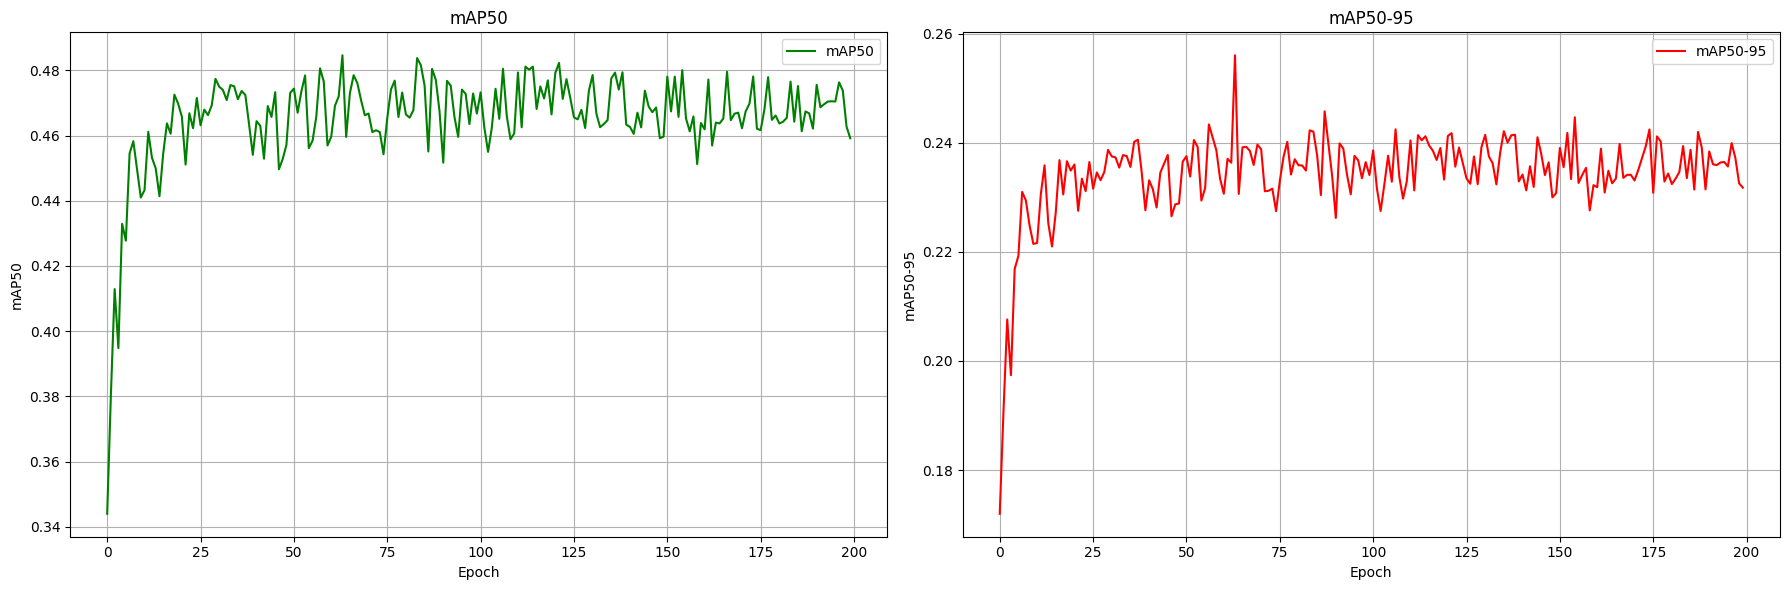

In [21]:
# Plot loss, mAP50 và mAP50-90 trên cùng một hàng ngang
plt.figure(figsize=(18, 6))

# Plot mAP50
plt.subplot(1, 2, 1)
plt.plot(mAP50_values, label='mAP50', color='green')
plt.xlabel('Epoch')
plt.ylabel('mAP50')
plt.title('mAP50')
plt.legend()
plt.grid(True)

# Plot mAP50-90
plt.subplot(1, 2, 2)
plt.plot(mAP50_95_values, label='mAP50-95', color='red')
plt.xlabel('Epoch')
plt.ylabel('mAP50-95')
plt.title('mAP50-95')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [32]:
# Tính toán mAP@50 và mAP@50-95 trên tập test_loader
mAP50, mAP50_95 = calculate_mAP(model_fasterrcnn, val_loader, device)

print(f"mAP@50 trên tập test: {mAP50}")
print(f"mAP@50-95 trên tập test: {mAP50_95}")


100%|██████████| 59/59 [00:03<00:00, 16.74it/s]


mAP@50 trên tập test: {'map': tensor(0.4592), 'map_50': tensor(0.4592), 'map_75': tensor(-1.), 'map_small': tensor(0.4617), 'map_medium': tensor(0.4547), 'map_large': tensor(0.), 'mar_1': tensor(0.4697), 'mar_10': tensor(0.4848), 'mar_100': tensor(0.4848), 'mar_small': tensor(0.4773), 'mar_medium': tensor(0.5000), 'mar_large': tensor(0.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1], dtype=torch.int32)}
mAP@50-95 trên tập test: {'map': tensor(0.2318), 'map_50': tensor(0.4592), 'map_75': tensor(-1.), 'map_small': tensor(0.2333), 'map_medium': tensor(0.2301), 'map_large': tensor(0.), 'mar_1': tensor(0.2500), 'mar_10': tensor(0.2576), 'mar_100': tensor(0.2576), 'mar_small': tensor(0.2500), 'mar_medium': tensor(0.2727), 'mar_large': tensor(0.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1], dtype=torch.int32)}


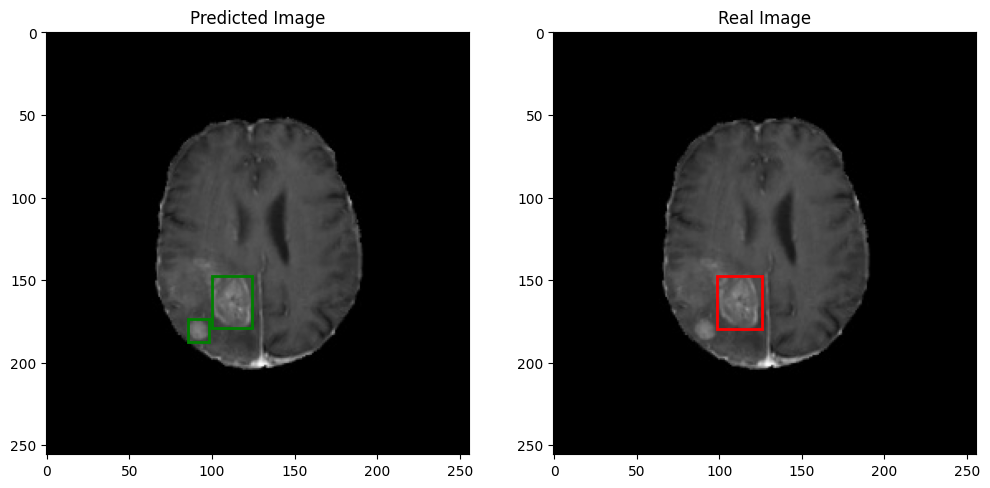

In [30]:
import random
import matplotlib.pyplot as plt

# Hàm dự đoán trên một ảnh ngẫu nhiên từ tập test và vẽ hình ảnh dự đoán cùng với hình ảnh thực tế
def predict_and_plot_random(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        # Chọn một ảnh ngẫu nhiên từ tập test
        image_index = random.randint(0, len(test_loader.dataset) - 1)
        image, target = test_loader.dataset[image_index]
        image = image.unsqueeze(0).to(device)  # Thêm chiều batch

        # Dự đoán trên ảnh đã chọn
        prediction = model(image)[0]

        # Chuyển về hình ảnh gốc
        image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        image = np.clip(image, 0, 1)

        # Tạo figure và plot hình ảnh
        plt.figure(figsize=(12, 6))

        # Plot hình ảnh thực tế
        plt.subplot(1, 2, 2)
        plt.imshow(image)
        plt.title('Real Image')

        # Plot bounding boxes của các vật thể thực tế
        for box in target['boxes']:
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                               edgecolor='r', facecolor='none', linewidth=2))

        # Plot bounding boxes của các vật thể được dự đoán
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        for box in prediction['boxes']:
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                               edgecolor='g', facecolor='none', linewidth=2))
        plt.title('Predicted Image')

        plt.show()

# Sử dụng hàm trên để dự đoán và vẽ hình ảnh
predict_and_plot_random(model_fasterrcnn, test_loader, device)